# Image Processing Experiments For CA Network

This notebook contains experiments done on various input png images in order to prepare them for input into a Neural Network of the same format as the ["Growing Neural Cellular Automata"](http://distill.pub/2020/growing-ca) article.

In [2]:
# Imports and Notebook Utilities
# %tensorflow_version 2.x

!pip install tensorflow_addons

import io
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

import math
import matplotlib.pyplot as plt

import requests
import PIL.Image
from IPython.display import Image

TARGET_SIZE = 40

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img


2022-12-10 00:48:05.757011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 00:48:05.929163: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Part 1: Overview Of Current Image Processing Pipeline

Currently, the way the original paper processes an input image is by querying 
[this](https://github.com/googlefonts/noto-emoji/tree/main/png/128) database of emoji unicodes and extracting the corresponding png image. These png images have a predesigned alpha channel that acts as a "living mask" determining which pixels are considered "alive" or "dead".

Below is the original code for loading an image in the appropriate format using this database, modified to return a tensor containing the alpha values.

In [2]:
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

In [3]:
def load_image(url, max_size=TARGET_SIZE):
  """load_image function as defined in original notebook,
    modified to extract and return alpha channel.
  """
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]

  # Modified code to extract alpha channel
  alpha_channel = img[..., 3]
  return img, alpha_channel

url = 'https://raw.githubusercontent.com/googlefonts/noto-emoji/main/png/128/emoji_u1f6e9.png'
orig_target_img, orig_alpha_channel = load_image(url, 48)

Here is the target image visualized (a plane emoji converted to a png):

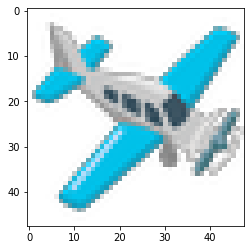

In [4]:
plt.imshow(orig_target_img)
plt.show()

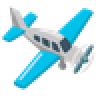

In [5]:
imshow(zoom(to_rgb(orig_target_img), 2), fmt='png')

And this is a heatmap of the alpha channel. As we can see, the alpha channel represents a black-and-white represenation of the original input image that demarcates between the actual object to be regenerated and the surrounding background.

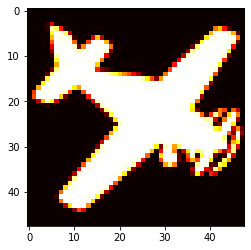

In [6]:
plt.imshow(orig_alpha_channel, cmap='hot', interpolation='nearest')
plt.show()

We also want to understand whether the distribution of alpha values is abrupt or gradual, which is illustrated by the following histogram. As we can see, the distribution is gradual, indicating continuous change from dead "cells" to living ones. As we move towards the edge of the object, the cells become progressively less "alive".

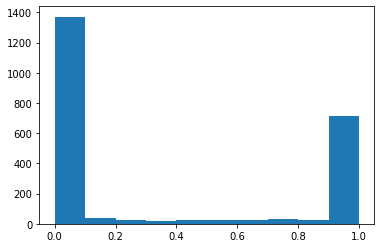

In [7]:
flattened = tf.reshape(orig_alpha_channel, [-1])
plt.hist(flattened)
plt.show()

## Part 2: Creating A Pipeline For Processing Any PNG 

Because a regular png file does not include an alpha channel, the following cells experiment with adding such a channel demarcating the status of "life" for an object's cells. 

The image we are working with is: 


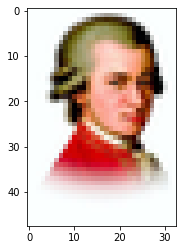

In [8]:
# Hyper-parameter denoting threshold for life
THRESHOLD = 0.01

def load_local_image(path, max_size=TARGET_SIZE, threshold=THRESHOLD, sigma=1.0):

  img = PIL.Image.open(path)
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  orig_img = img.copy()

  # Concatenate alpha channel initialized with zeros
  target_img = np.concatenate([img, np.zeros_like(img[..., :1])], axis=-1)

  for i in range(target_img.shape[0]):
    for j in range(target_img.shape[1]):
      if (target_img[i][j][0] > 0.95 and target_img[i][j][1] > 0.95 and target_img[i][j][2] > 0.95):
        target_img[i][j][0] = 0
        target_img[i][j][1] = 0
        target_img[i][j][2] = 0

        # Append the alpha channel
      else:
        l2_norm = math.sqrt(target_img[i][j][0]**2 + target_img[i][j][1]**2 + target_img[i][j][2]**2)
        if l2_norm > threshold:
          target_img[i][j][3] = 1

  # Perform guassian blurring to smooth out boundaries
  alpha_channel = tfa.image.gaussian_filter2d(image=target_img[..., 3]  , sigma=sigma, padding='CONSTANT')
  target_img[..., 3] = alpha_channel
  
  # Premultiply RGB by Alpha
  target_img[..., :3] *= target_img[..., 3:]

  return target_img, alpha_channel, orig_img

load_path = 'mozart1.png'
target_img, alpha_channel, orig_img = load_local_image(load_path, 48)

print('The image we are working with is: ')
plt.imshow(orig_img)
plt.show()

The above code modifies the provided load_image() function to take as input some png, and construct an alpha channel to correspond to that image. In the below cells we will experiment with changing the standard deviation in the guassian filter to find a good value.

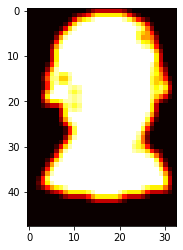

In [9]:
plt.imshow(alpha_channel, cmap='hot', interpolation='nearest')
plt.show()

The above heatmap was plotted with a standard deviation of 1. Now we will experiment with standard deviation values from 0.6 to 0.9:

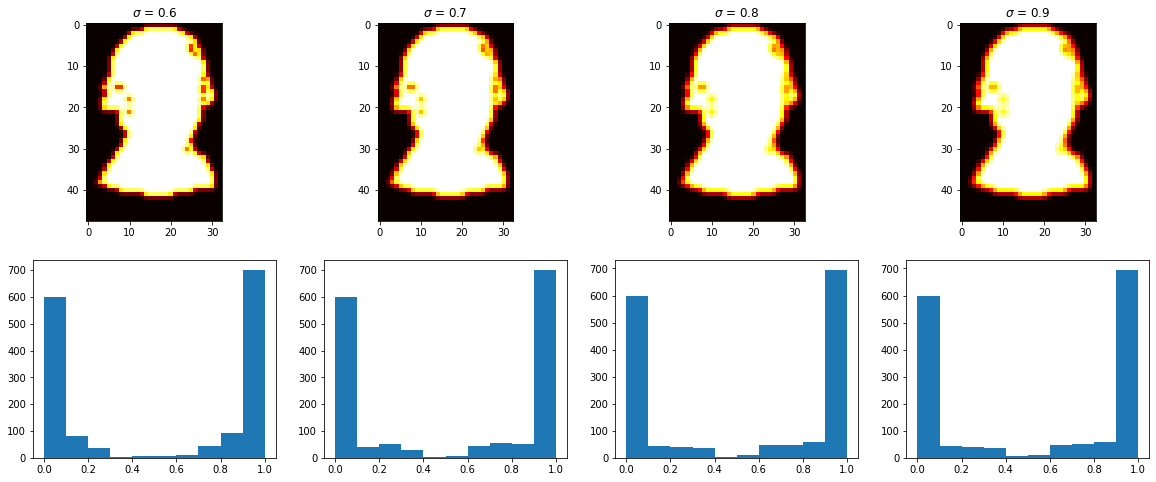

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

sigmas = [0.6, 0.7, 0.8, 0.9]

for i, sigma in enumerate(sigmas):
  _, alpha_channel, _ = load_local_image(load_path, 48, sigma=sigma)
  ax[0][i].imshow(alpha_channel, cmap='hot', interpolation='nearest')
  ax[0][i].set_title(f'$\sigma$ = {sigma}')

  flattened = tf.reshape(alpha_channel, [-1])
  ax[1][i].hist(flattened) 

fig.show()

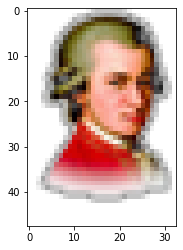

In [11]:
target_img, alpha_channel, _ = load_local_image(load_path, 48, sigma=0.8)
plt.imshow(target_img)
plt.show()

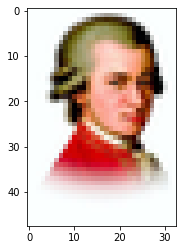

In [12]:
plt.imshow(orig_img)
plt.show()

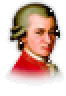

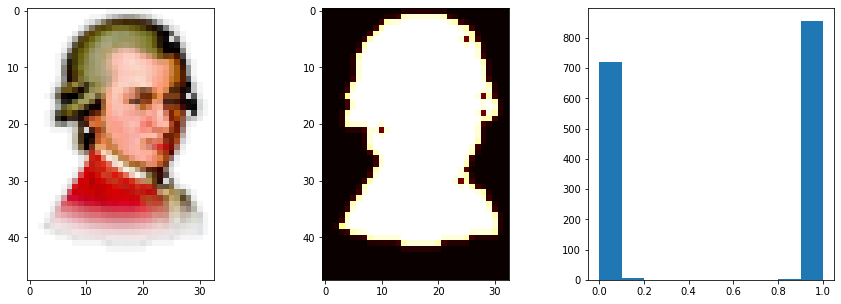

In [13]:
target_img, alpha_channel, _ = load_local_image(load_path, 48, sigma=0.4, threshold=0)

imshow(zoom(to_rgb(target_img), 2), fmt='png')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(target_img)
ax[1].imshow(alpha_channel, cmap='hot', interpolation='nearest')

flattened = tf.reshape(alpha_channel, [-1])
ax[2].hist(flattened) 

fig.show()


In [14]:
load_path = 'sleigh.png'
target_img, alpha_channel, orig_img = load_local_image(load_path, 48)

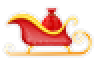

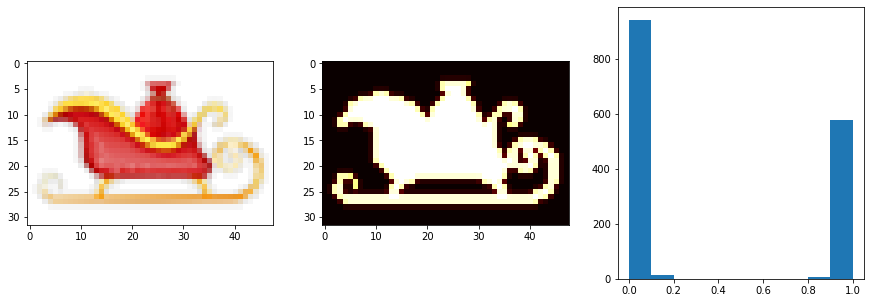

In [ ]:
target_img, alpha_channel, _ = load_local_image(load_path, 48, sigma=0.4, threshold=0)

imshow(zoom(to_rgb(target_img), 2), fmt='png')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(target_img)
ax[1].imshow(alpha_channel, cmap='hot', interpolation='nearest')

flattened = tf.reshape(alpha_channel, [-1])
ax[2].hist(flattened) 

fig.show()



## Part 3: Images With Detailed Semantic Information

The above images are pngs of single objects, which means there is very little information conveyed in one such image, and so the CA rules that need to be learned are not as large as they may have to be for more detailed input. Here we deal with processing such images.

In [15]:
load_path = 'starry-night.png'
# load_path = 'bob-ross-painting.png'
target_img, alpha_channel, orig_img = load_local_image(load_path, 48)

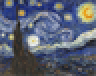

[[[0.1882353  0.20784314 0.3019608 ]
  [0.15294118 0.19215687 0.3372549 ]
  [0.2627451  0.32156864 0.5019608 ]
  ...
  [0.27450982 0.3254902  0.47843137]
  [0.19215687 0.23529412 0.42352942]
  [0.20392157 0.2509804  0.4117647 ]]

 [[0.14117648 0.17254902 0.32156864]
  [0.13333334 0.1764706  0.3529412 ]
  [0.34901962 0.41960785 0.6       ]
  ...
  [0.49411765 0.5176471  0.47058824]
  [0.34901962 0.39607844 0.5137255 ]
  [0.2784314  0.31764707 0.49803922]]

 [[0.12941177 0.16470589 0.3254902 ]
  [0.15294118 0.1882353  0.36078432]
  [0.3137255  0.37254903 0.54509807]
  ...
  [0.7137255  0.7019608  0.49411765]
  [0.59607846 0.6392157  0.5411765 ]
  [0.45490196 0.49411765 0.5529412 ]]

 ...

 [[0.23529412 0.23529412 0.2901961 ]
  [0.2509804  0.2509804  0.29411766]
  [0.27450982 0.2627451  0.26666668]
  ...
  [0.26666668 0.24313726 0.22352941]
  [0.21960784 0.23529412 0.23921569]
  [0.24313726 0.25490198 0.2901961 ]]

 [[0.30980393 0.28235295 0.25490198]
  [0.25882354 0.24705882 0.24705882]


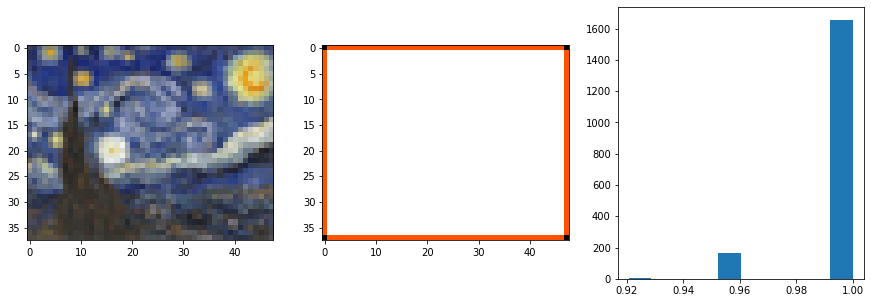

In [16]:
target_img, alpha_channel, orig_img = load_local_image(load_path, 48, sigma=0.4, threshold=0)

imshow(zoom(to_rgb(target_img), 2), fmt='png')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(target_img)
ax[1].imshow(alpha_channel, cmap='hot', interpolation='nearest')

flattened = tf.reshape(alpha_channel, [-1])
ax[2].hist(flattened) 

fig.show()

print(orig_img)

In [31]:
def load_alive_image(path, max_size=TARGET_SIZE, threshold=THRESHOLD, sigma=1.0):

  img = PIL.Image.open(path)
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  orig_img = img.copy()

  # Concatenate alpha channel initialized with zeros
  target_img = np.concatenate([img, np.ones_like(img[..., :1])], axis=-1)

  # Premultiply RGB by Alpha
  target_img[..., :3] *= target_img[..., 3:]

  return target_img, target_img[..., 3], orig_img

load_path = 'bob-ross-painting.png'
# load_path = 'starry-night.png'
target_img, alpha_channel, orig_img = load_alive_image(load_path, max_size=125)

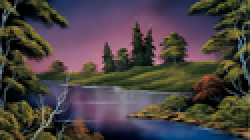

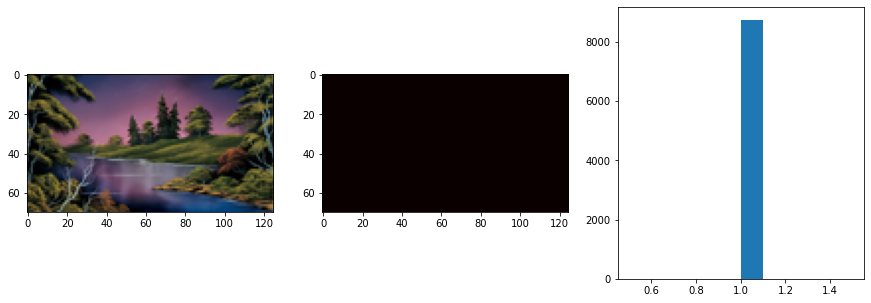

In [32]:
imshow(zoom(to_rgb(target_img), 2), fmt='png')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(target_img)
ax[1].imshow(alpha_channel, cmap='hot', interpolation='nearest')

flattened = tf.reshape(alpha_channel, [-1])
ax[2].hist(flattened) 

fig.show()

In [ ]:
target_img.shape

(45, 80, 4)

In [ ]:
orig_img.shape

(45, 80, 3)

The image we are working with is: 


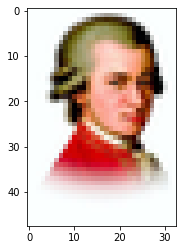

In [ ]:
# Hyper-parameter denoting threshold for life
THRESHOLD = 0.01

def load_local_image(path, max_size=TARGET_SIZE, threshold=THRESHOLD, sigma=1.0):

  img = PIL.Image.open(path)
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  orig_img = img.copy()

  # Concatenate alpha channel initialized with zeros
  target_img = np.concatenate([img, np.zeros_like(img[..., :1])], axis=-1)

  for i in range(target_img.shape[0]):
    for j in range(target_img.shape[1]):
      if (target_img[i][j][0] > 0.95 and target_img[i][j][1] > 0.95 and target_img[i][j][2] > 0.95):
        target_img[i][j][0] = 0
        target_img[i][j][1] = 0
        target_img[i][j][2] = 0

        # Append the alpha channel
      else:
        l2_norm = math.sqrt(target_img[i][j][0]**2 + target_img[i][j][1]**2 + target_img[i][j][2]**2)
        if l2_norm > threshold:
          target_img[i][j][3] = 1

  # Perform guassian blurring to smooth out boundaries
  alpha_channel = tfa.image.gaussian_filter2d(image=target_img[..., 3]  , sigma=sigma, padding='CONSTANT')
  target_img[..., 3] = alpha_channel
  
  # Premultiply RGB by Alpha
  target_img[..., :3] *= target_img[..., 3:]

  return target_img, alpha_channel, orig_img

load_path = 'mozart1.png'
target_img, alpha_channel, orig_img = load_local_image(load_path, 48)

print('The image we are working with is: ')
plt.imshow(orig_img)
plt.show()